In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# undersampling한 dummy만 분석

이를 위한 데이터 셋 생성과정

In [ ]:
# df_12hrs = pd.read_csv("/content/drive/Shareddrives/Multicampus/Preprocessing/unit_num_12hrs.csv")

In [ ]:
# df_12hrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649659 entries, 0 to 649658
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   SUBJECT_ID  649659 non-null  int64  
 1   ITEMID      649659 non-null  int64  
 2   LABEL       649659 non-null  object 
 3   RESULT      649535 non-null  float64
 4   VALUEUOM    649659 non-null  object 
 5   CHARTTIME   649659 non-null  object 
 6   ADMITTIME   649659 non-null  object 
 7   24hrs       649659 non-null  object 
 8   hours       649659 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 44.6+ MB


In [ ]:
df_adm = pd.read_csv("/content/drive/Shareddrives/Multicampus/mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz")

In [ ]:
df_adm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [ ]:
# 입원 및 퇴원 시간 datetime 형태로 변경
df_adm['ADMITTIME'] = pd.to_datetime(df_adm['ADMITTIME'])
df_adm['DISCHTIME'] = pd.to_datetime(df_adm['DISCHTIME'])

# 체류시간 계산(일단위)
df_adm['stay'] = (df_adm['DISCHTIME'] - df_adm['ADMITTIME']).dt.total_seconds() / 86400

In [ ]:
df_adm[['ADMITTIME','DISCHTIME','stay']].head()

ADMITTIME           DISCHTIME      stay
0 2196-04-09 12:26:00 2196-04-10 15:54:00  1.144444
1 2153-09-03 07:15:00 2153-09-08 19:10:00  5.496528
2 2157-10-18 19:34:00 2157-10-25 14:00:00  6.768056
3 2139-06-06 16:14:00 2139-06-09 12:48:00  2.856944
4 2160-11-02 02:06:00 2160-11-05 14:55:00  3.534028

In [ ]:
df_adm['stay'].describe()  #음수인 값 있음 => 이상치 처리 필요

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: stay, dtype: float64

In [ ]:
df_adm[df_adm['stay'] < 0]  #98개 데이터

ROW_ID  SUBJECT_ID  ...  HAS_CHARTEVENTS_DATA      stay
425       534         417  ...                     1 -0.372917
456       237         181  ...                     1 -0.138889
692       644         516  ...                     0 -0.797222
1911     1640        1334  ...                     1 -0.113194
1970     1699        1381  ...                     1 -0.100694
...       ...         ...  ...                   ...       ...
57233   57980       96810  ...                     1 -0.359722
57559   58635       98943  ...                     1 -0.335417
57902   58720       99207  ...                     1 -0.332639
58346   55950       90642  ...                     1 -0.108333
58884   57477       95367  ...                     1 -0.094444

[98 rows x 20 columns]

In [ ]:
# 체류시간이 0보다 작은 값 drop
df_adm = df_adm[df_adm['stay'] > 0]

In [ ]:
# 이상치 유무 확인
df_adm['stay'].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: stay, dtype: float64

In [ ]:
df_adm.head()

ROW_ID  SUBJECT_ID  ...  HAS_CHARTEVENTS_DATA      stay
0      21          22  ...                     1  1.144444
1      22          23  ...                     1  5.496528
2      23          23  ...                     1  6.768056
3      24          24  ...                     1  2.856944
4      25          25  ...                     1  3.534028

[5 rows x 20 columns]

In [ ]:
df_adm['death'] = df_adm['DEATHTIME'].notnull().map({True:1, False:0})

In [ ]:
df_adm['death'].sum()  #5774명이 병원 내에서 사망

5774

In [ ]:
df_adm['HOSPITAL_EXPIRE_FLAG'].sum()  #5774명이 병원 내에서 사망 / 다시 확인차원

5774

In [ ]:
df_adm['stay'].loc[df_adm['death'] == 0 ].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: stay, dtype: float64

In [ ]:
mean_stay = df_adm['stay'].loc[df_adm['death'] == 0].mean()
median_stay = df_adm['stay'].loc[df_adm['death'] == 0].median()

print(mean_stay)
print(median_stay)

10.138173704219758
6.565972222222222


In [ ]:
df_id = pd.read_csv("/content/drive/Shareddrives/Multicampus/Preprocessing/undersampling_id.csv")

In [ ]:
df_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8942 entries, 0 to 8941
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   SUBJECT_ID  8942 non-null   int64
dtypes: int64(1)
memory usage: 70.0 KB


In [ ]:
df_dummy = pd.read_csv("/content/drive/Shareddrives/Multicampus/Preprocessing/0414_dummy(최종).csv")

In [ ]:
df_dummy

SUBJECT_ID  AGE  staytime  ... ETH_WHITE  GEN_F  GEN_M
0              22   64         2  ...         1      1      0
1              24   39         3  ...         1      0      1
2              25   58         4  ...         1      0      1
3              26   72         7  ...         0      0      1
4              28   74         6  ...         1      0      1
...           ...  ...       ...  ...       ...    ...    ...
30919       98794   78         5  ...         1      0      1
30920       98797   88         1  ...         1      0      1
30921       98800   19         3  ...         1      1      0
30922       98802   83         1  ...         1      1      0
30923       98805   42         9  ...         1      0      1

[30924 rows x 66 columns]

In [ ]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30924 entries, 0 to 30923
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   SUBJECT_ID                  30924 non-null  int64 
 1   AGE                         30924 non-null  int64 
 2   staytime                    30924 non-null  int64 
 3   new_code                    30924 non-null  object
 4   blood                       30924 non-null  int64 
 5   circulatory                 30924 non-null  int64 
 6   congenital                  30924 non-null  int64 
 7   digestive                   30924 non-null  int64 
 8   endocrine                   30924 non-null  int64 
 9   genitourinary               30924 non-null  int64 
 10  infectious                  30924 non-null  int64 
 11  injury                      30924 non-null  int64 
 12  mental                      30924 non-null  int64 
 13  misc                        30924 non-null  in

In [ ]:
df_dummy.drop(['staytime','new_code','AGEG1','AGE'], axis=1, inplace=True)

In [ ]:
df_id_dummy = df_id.merge(df_dummy, on='SUBJECT_ID', how='inner')

In [ ]:
df_id_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8942 entries, 0 to 8941
Data columns (total 62 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   SUBJECT_ID                  8942 non-null   int64 
 1   blood                       8942 non-null   int64 
 2   circulatory                 8942 non-null   int64 
 3   congenital                  8942 non-null   int64 
 4   digestive                   8942 non-null   int64 
 5   endocrine                   8942 non-null   int64 
 6   genitourinary               8942 non-null   int64 
 7   infectious                  8942 non-null   int64 
 8   injury                      8942 non-null   int64 
 9   mental                      8942 non-null   int64 
 10  misc                        8942 non-null   int64 
 11  muscular                    8942 non-null   int64 
 12  neoplasms                   8942 non-null   int64 
 13  nervous                     8942 non-null   int6

In [ ]:
df_id_dummy['AGEG2'].unique()

array(['senior', 'young_adult', 'middle_adult'], dtype=object)

In [ ]:
df_id_dummy = pd.get_dummies(df_id_dummy, columns=['AGEG2'])

In [ ]:
df_id_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8942 entries, 0 to 8941
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   SUBJECT_ID                  8942 non-null   int64
 1   blood                       8942 non-null   int64
 2   circulatory                 8942 non-null   int64
 3   congenital                  8942 non-null   int64
 4   digestive                   8942 non-null   int64
 5   endocrine                   8942 non-null   int64
 6   genitourinary               8942 non-null   int64
 7   infectious                  8942 non-null   int64
 8   injury                      8942 non-null   int64
 9   mental                      8942 non-null   int64
 10  misc                        8942 non-null   int64
 11  muscular                    8942 non-null   int64
 12  neoplasms                   8942 non-null   int64
 13  nervous                     8942 non-null   int64
 14  pregnanc

In [ ]:
df_id_dummy.isnull().values.sum()  #결측값 없음

0

In [ ]:
df_clean = pd.merge(df_adm[['SUBJECT_ID','stay']], df_id_dummy, 
                    on='SUBJECT_ID', how='inner')

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8906 entries, 0 to 8905
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SUBJECT_ID                  8906 non-null   int64  
 1   stay                        8906 non-null   float64
 2   blood                       8906 non-null   int64  
 3   circulatory                 8906 non-null   int64  
 4   congenital                  8906 non-null   int64  
 5   digestive                   8906 non-null   int64  
 6   endocrine                   8906 non-null   int64  
 7   genitourinary               8906 non-null   int64  
 8   infectious                  8906 non-null   int64  
 9   injury                      8906 non-null   int64  
 10  mental                      8906 non-null   int64  
 11  misc                        8906 non-null   int64  
 12  muscular                    8906 non-null   int64  
 13  neoplasms                   8906 

In [ ]:
df_clean['HOSPITAL_EXPIRE_FLAG'].sum()  #병원 내 사망자: 3646명

3646

In [ ]:
df_clean.isnull().values.sum()  #결측값 없음

0

In [ ]:
df_clean.to_csv("/content/drive/Shareddrives/Multicampus/Preprocessing/dummy_clean.csv", index=False)

# undersampling한 dummy데이터 예측 모델 생성

age: random_state=0, death 분리x, undersampling_dummy

In [ ]:
X = df_clean.drop(columns=['SUBJECT_ID','stay','HOSPITAL_EXPIRE_FLAG'])
y = df_clean['stay']

In [ ]:
X

blood  circulatory  ...  AGEG2_senior  AGEG2_young_adult
0         0            6  ...             1                  0
1         0            2  ...             1                  0
2         0            3  ...             0                  0
3         1            1  ...             1                  0
4         1            1  ...             1                  0
...     ...          ...  ...           ...                ...
8901      1            4  ...             1                  0
8902      0            0  ...             0                  0
8903      0            3  ...             1                  0
8904      0            1  ...             1                  0
8905      0            1  ...             1                  0

[8906 rows x 62 columns]

In [ ]:
# train/test 데이터 80:20으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape[0])
print(X_test.shape[0])

7124
1782


In [ ]:
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0),
          SVR(),
          DecisionTreeRegressor()]

results_r2 = {}
results_MAE = {}
results_RMSE = {}

for model in models:
    
    # 모델 정의 및 모델 형성
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # 예측
    y_pred = reg_model.predict(X_test)
    
    # 모델 이름
    name = str(model).split("(")[0]

    results_r2[name] = r2_score(y_test, y_pred)
    results_MAE[name] = metrics.mean_absolute_error(y_test, y_pred)
    results_RMSE[name] = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.
SVR done.
DecisionTreeRegressor done.


In [ ]:
results_r2

{'DecisionTreeRegressor': -0.41723265196176795,
 'GradientBoostingRegressor': 0.19337725696691177,
 'KNeighborsRegressor': 0.06639668501300788,
 'LinearRegression': -6.514427543487243e+18,
 'RandomForestRegressor': 0.1729359228813735,
 'SGDRegressor': 0.20696066173656624,
 'SVR': 0.12664095626269434}

In [ ]:
results_MAE

{'DecisionTreeRegressor': 8.085296379432181,
 'GradientBoostingRegressor': 5.989424363741054,
 'KNeighborsRegressor': 6.290143331462777,
 'LinearRegression': 661526642.060502,
 'RandomForestRegressor': 6.194727301291316,
 'SGDRegressor': 5.99521151142441,
 'SVR': 5.658287405212472}

In [ ]:
results_RMSE

{'DecisionTreeRegressor': 13.025176923735478,
 'GradientBoostingRegressor': 9.826487087446676,
 'KNeighborsRegressor': 10.57168584516138,
 'LinearRegression': 27925514630.61867,
 'RandomForestRegressor': 9.950218904762133,
 'SGDRegressor': 9.743397521528605,
 'SVR': 10.224909368971375}

# undersampling한 dummy데이터 예측 모델 생성

age: random_state=42, death분리o, undersampling_dummy

In [ ]:
# train/test 데이터 80:20으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape[0])
print(X_test.shape[0])

7124
1782


In [ ]:
# 이전과정에서 r2값이 음수였던 모델은 제외한 경우
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          RandomForestRegressor(random_state = 0),
          SVR()]

results_r2 = {}
results_MAE = {}
results_RMSE = {}

for model in models:
    
    # 모델 정의 및 모델 형성
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # 예측
    y_pred = reg_model.predict(X_test)
    
    # 모델 이름
    name = str(model).split("(")[0]

    results_r2[name] = r2_score(y_test, y_pred)
    results_MAE[name] = metrics.mean_absolute_error(y_test, y_pred)
    results_RMSE[name] = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
RandomForestRegressor done.
SVR done.


In [ ]:
results_r2

{'GradientBoostingRegressor': 0.24428771583056563,
 'RandomForestRegressor': 0.2319990005721635,
 'SGDRegressor': 0.22044804436549792,
 'SVR': 0.12269051196609859}

In [ ]:
results_MAE

{'GradientBoostingRegressor': 5.963997986325362,
 'RandomForestRegressor': 6.136428993213292,
 'SGDRegressor': 6.055270194964708,
 'SVR': 5.7835500803786255}

In [ ]:
results_RMSE

{'GradientBoostingRegressor': 10.616990346879602,
 'RandomForestRegressor': 10.702964235284927,
 'SGDRegressor': 10.783151682179879,
 'SVR': 11.439303820537079}

GrandientBoostingRegressor 모델이 가장 나은 결과를 보였다

그리드 이용해 가장 좋은 설정값 찾기

In [ ]:
# train/test 데이터 80:20으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tuned_parameters = [{'n_estimators': [100, 200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['ls', 'lad']}]

# 모델 생성
reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# grid 결과 출력
print(grid.best_score_)
print(grid.best_estimator_)

0.2002528697495647
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))
# 기본으로 놓고 한 것이 더 잘 나왔다.

Optimized R2 score is: 0.243474


# undersampling한 dummy데이터에서 사망여부 분리한 데이터로 분석 

이를 위한 데이터셋 준비과정

age: random_state=42, death분리o, undersampling_dummy


In [ ]:
df_clean

SUBJECT_ID       stay  ...  AGEG2_senior  AGEG2_young_adult
0             30   5.013889  ...             1                  0
1             31   7.647917  ...             1                  0
2             32  19.197917  ...             0                  0
3             41  27.218750  ...             1                  0
4            364   7.795139  ...             1                  0
...          ...        ...  ...           ...                ...
8901       98753  19.440278  ...             1                  0
8902       98762   6.676389  ...             0                  0
8903       98768   1.940972  ...             1                  0
8904       98794   4.145833  ...             1                  0
8905       98797   0.662500  ...             1                  0

[8906 rows x 65 columns]

In [ ]:
df_death = df_clean[df_clean['HOSPITAL_EXPIRE_FLAG']==1]
df_surv = df_clean[df_clean['HOSPITAL_EXPIRE_FLAG']==0]

## 사망한 경우의 체류시간

In [ ]:
X = df_death.drop(columns=['SUBJECT_ID','stay','HOSPITAL_EXPIRE_FLAG'])
y = df_death['stay']

In [ ]:
# train/test 데이터 80:20으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape[0])
print(X_test.shape[0])

2916
730


In [ ]:
# 이전과정에서 r2값이 음수였던 모델은 제외한 경우
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          RandomForestRegressor(random_state = 0),
          SVR()]

results_r2 = {}
results_MAE = {}
results_RMSE = {}

for model in models:
    
    # 모델 정의 및 모델 형성
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # 예측
    y_pred = reg_model.predict(X_test)
    
    # 모델 이름
    name = str(model).split("(")[0]

    results_r2[name] = r2_score(y_test, y_pred)
    results_MAE[name] = metrics.mean_absolute_error(y_test, y_pred)
    results_RMSE[name] = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
RandomForestRegressor done.
SVR done.


In [ ]:
results_r2

{'GradientBoostingRegressor': 0.2145661419263799,
 'RandomForestRegressor': 0.15772629662603244,
 'SGDRegressor': 0.20814366759205838,
 'SVR': 0.08799478145020834}

In [ ]:
results_MAE

{'GradientBoostingRegressor': 6.408294272594179,
 'RandomForestRegressor': 6.76164598612168,
 'SGDRegressor': 6.315531199360212,
 'SVR': 6.098031165380235}

In [ ]:
results_RMSE

{'GradientBoostingRegressor': 10.332246434800032,
 'RandomForestRegressor': 10.69957599112279,
 'SGDRegressor': 10.374403699543038,
 'SVR': 11.133676757888646}

## 퇴원하신 경우

In [ ]:
X = df_surv.drop(columns=['SUBJECT_ID','stay','HOSPITAL_EXPIRE_FLAG'])
y = df_surv['stay']

In [ ]:
# train/test 데이터 80:20으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape[0])
print(X_test.shape[0])

4208
1052


In [ ]:
# 이전과정에서 r2값이 음수였던 모델은 제외한 경우
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          RandomForestRegressor(random_state = 0),
          SVR()]

results_r2 = {}
results_MAE = {}
results_RMSE = {}

for model in models:
    
    # 모델 정의 및 모델 형성
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # 예측
    y_pred = reg_model.predict(X_test)
    
    # 모델 이름
    name = str(model).split("(")[0]

    results_r2[name] = r2_score(y_test, y_pred)
    results_MAE[name] = metrics.mean_absolute_error(y_test, y_pred)
    results_RMSE[name] = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
RandomForestRegressor done.
SVR done.


In [ ]:
results_r2

{'GradientBoostingRegressor': 0.1729481979281674,
 'RandomForestRegressor': 0.142548325131573,
 'SGDRegressor': 0.16780756854016365,
 'SVR': 0.11327163101839965}

In [ ]:
results_MAE

{'GradientBoostingRegressor': 5.1948196305146555,
 'RandomForestRegressor': 5.30318755581143,
 'SGDRegressor': 5.237541747634136,
 'SVR': 4.8896429505105505}

In [ ]:
results_RMSE

{'GradientBoostingRegressor': 9.191604718936535,
 'RandomForestRegressor': 9.359007812206052,
 'SGDRegressor': 9.220126171689733,
 'SVR': 9.517443006542594}

# 검사결과 데이터 포함한 데이터로 분석

undersampling + dummy데이터 + 검사결과데이터

이를 위한 데이터셋 준비과정

In [1]:
from sklearn.impute import SimpleImputer
def mean_z(data, target, strategy='mean'):
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','stay'],axis=1)

    imputer = SimpleImputer(strategy=strategy)
    imputed = imputer.fit_transform(content)
    df_imputed = pd.DataFrame(imputed, columns=content.columns)

In [2]:
def mean_z(data, target, strategy='mean'):
    content = data.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','stay'],axis=1)

    imputer = SimpleImputer(strategy=strategy)
    imputed = imputer.fit_transform(content)
    df_imputed = pd.DataFrame(imputed, columns=content.columns)
        
    X = df_imputed
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 표준화
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    return X_train, X_test, y_train, y_test


In [3]:
path = "/content/drive/Shareddrives/Multicampus/Preprocessing/"

In [6]:
dummy = pd.read_csv(path+"0414_dummy(최종).csv")

In [7]:
pivot12_under_ind = pd.read_csv(path+"pivot12_mnmx_under_ind.csv")

In [8]:
u_dummy_pivot12_ind = pd.merge(dummy, pivot12_under_ind, how='inner', on='SUBJECT_ID')

In [9]:
len(u_dummy_pivot12_ind['SUBJECT_ID'])

8942

In [10]:
df_clean = pd.read_csv(path+"dummy_clean.csv")

In [11]:
df_final = pd.merge(df_clean[['SUBJECT_ID','stay']], u_dummy_pivot12_ind,
                    on='SUBJECT_ID', how='inner')

In [12]:
len(df_final['SUBJECT_ID'])

8906

In [13]:
df_final.head()

SUBJECT_ID       stay  AGE  ...  51275_max_i 51279_max_i  51301_max_i
0          30   5.013889   90  ...            0           0            0
1          31   7.647917   72  ...            1           1            1
2          32  19.197917   45  ...            0           0            0
3          41  27.218750   56  ...            1           1            1
4         364   7.795139   71  ...            0           0            0

[5 rows x 151 columns]

In [14]:
df_final_clean = df_final.drop(columns=['new_code','staytime','AGEG1','AGEG2'])

In [15]:
df_final_clean.head(2)

SUBJECT_ID      stay  AGE  ...  51275_max_i  51279_max_i  51301_max_i
0          30  5.013889   90  ...            0            0            0
1          31  7.647917   72  ...            1            1            1

[2 rows x 147 columns]

In [16]:
mean_z_ind = mean_z(df_final_clean, 'stay')
X_train, X_test, y_train, y_test = mean_z_ind

In [17]:
print(X_train.shape[0])
print(X_test.shape[0])

7124
1782


## 예측모델

In [ ]:
# models = [SGDRegressor(random_state = 0), 
#           GradientBoostingRegressor(random_state = 0), 
#           LinearRegression(),
#           KNeighborsRegressor(),
#           RandomForestRegressor(random_state = 0),
#           SVR(),
#           DecisionTreeRegressor()]

# 이전과정에서 r2값이 음수였던 모델은 제외한 경우
models = [GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0),
          SVR()]

results_r2 = {}
results_MAE = {}
results_RMSE = {}

for model in models:
    
    # 모델 정의 및 모델 형성
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # 예측
    y_pred = reg_model.predict(X_test)
    
    # 모델 이름
    name = str(model).split("(")[0]

    results_r2[name] = r2_score(y_test, y_pred)
    results_MAE[name] = metrics.mean_absolute_error(y_test, y_pred)
    results_RMSE[name] = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('{} done.'.format(name))

GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.
SVR done.


In [ ]:
results_r2

{'GradientBoostingRegressor': 0.2470343673446298,
 'KNeighborsRegressor': 0.03242173645514235,
 'LinearRegression': 0.23528215368353667,
 'RandomForestRegressor': 0.22159509244957676,
 'SVR': 0.07235571634373472}

In [ ]:
results_MAE

{'GradientBoostingRegressor': 5.914573699445567,
 'KNeighborsRegressor': 6.53311143845866,
 'LinearRegression': 6.02938119205485,
 'RandomForestRegressor': 6.108879068072703,
 'SVR': 5.686650093600332}

In [ ]:
results_RMSE

{'GradientBoostingRegressor': 10.597678951391643,
 'KNeighborsRegressor': 12.013408179213242,
 'LinearRegression': 10.680062503668049,
 'RandomForestRegressor': 10.775215490974173,
 'SVR': 11.762886809362579}

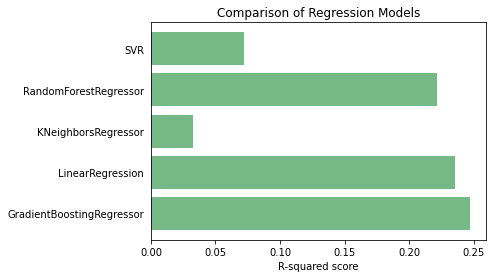

In [ ]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results_r2))
ax.barh(ind, list(results_r2.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results_r2.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig(path+'compare_models.png', bbox_inches = 'tight')

## Gridsearch

### GradientBoostingRegressor

In [ ]:
tuned_parameters = [{'n_estimators': [100, 200, 300],
                     'max_depth' : [2, 3, 4]}]

# 모델 생성
reg_model = GradientBoostingRegressor(random_state=42)  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# grid 결과 출력
print(grid.best_score_)
print(grid.best_estimator_)

0.22032053063338547
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.253683


### RandomForestRegressor

In [ ]:
# 모델생성
rf = RandomForestRegressor(max_depth=18, n_estimators=1000, random_state=0)
rf.fit(X_train, y_train)
# 예측
y_pred = rf.predict(X_test)
# 평가
print(r2_score(y_test, y_pred))

0.21950236255536615


In [ ]:
tuned_parameters = [{#'max_depth' : [7, 9, 11],
                     'min_samples_split' : [80,90]}]

# 모델 생성
reg_model = RandomForestRegressor(max_depth=18, random_state=0, n_estimators=1000)  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# grid 결과 출력
print(grid.best_score_)
print(grid.best_estimator_)

0.1905611812264035
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=18, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=80, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [ ]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))
# 기본으로 놓고 한 것이 더 잘 나왔다.

Optimized R2 score is: 0.210826


## GradientBoostingRegressor MDI

In [ ]:
# MDI
rf = GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
features = df_final_clean.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','stay'], axis=1).columns.values
df_feat_imp = pd.DataFrame({'columns':features, 'importances':rf.feature_importances_})
df_feat_imp_30 = df_feat_imp.sort_values(by=['importances'], ascending=False).head(30)
df_feat_imp_30

columns  importances
7       infectious     0.207342
16     respiratory     0.129649
8           injury     0.114140
17            skin     0.063216
4        digestive     0.062865
81       50820_max     0.043079
6    genitourinary     0.034267
63       50893_min     0.028193
1            blood     0.026217
0              AGE     0.022398
2      circulatory     0.016808
75       51254_min     0.014507
14       pregnancy     0.014053
60       50820_min     0.013390
68       50970_min     0.010906
13         nervous     0.010367
101      51301_max     0.009568
67       50960_min     0.009058
64       50902_min     0.008586
80       51301_min     0.008003
72       51200_min     0.007618
85       50902_max     0.007323
93       51200_max     0.006554
98       51265_max     0.005957
97       51256_max     0.005898
84       50893_max     0.005807
76       51256_min     0.005724
100      51279_max     0.005115
86       50912_max     0.005040
89       50970_max     0.004947

In [ ]:
gbr_feature = df_feat_imp_30['columns'].index
gbr_feature

Int64Index([  7,  16,   8,  17,   4,  81,   6,  63,   1,   0,   2,  75,  14,
             60,  68,  13, 101,  67,  64,  80,  72,  85,  93,  98,  97,  84,
             76, 100,  86,  89],
           dtype='int64')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


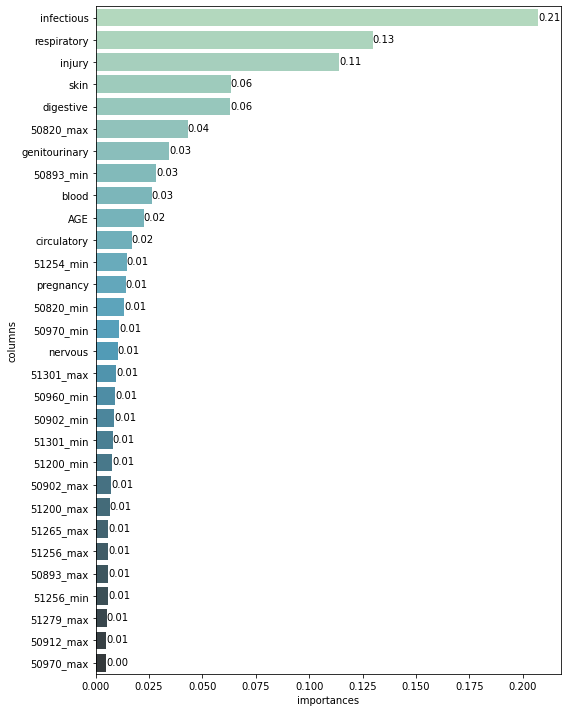

In [ ]:
# 시각화
fig = plt.figure(figsize=(8,10))
ax = sns.barplot(df_feat_imp_30['importances'],df_feat_imp_30['columns'], palette='GnBu_d')
ax.set_yticklabels(df_feat_imp_30['columns'], fontsize=10)

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()))
  initialx+=1

plt.tight_layout()
plt.show()

## RandomForestRegressor MDI

In [18]:
# MDI
rf = RandomForestRegressor(max_depth=18, n_estimators=1000, random_state=0)
rf.fit(X_train, y_train)
features = df_final_clean.drop(['SUBJECT_ID','HOSPITAL_EXPIRE_FLAG','stay'], axis=1).columns.values
df_feat_imp = pd.DataFrame({'columns':features, 'importances':rf.feature_importances_})
df_feat_imp_30 = df_feat_imp.sort_values(by=['importances'], ascending=False).head(30)
df_feat_imp_30

columns  importances
7       infectious     0.088996
16     respiratory     0.061080
8           injury     0.048853
4        digestive     0.029796
81       50820_max     0.026463
66       50931_min     0.024937
0              AGE     0.024078
84       50893_max     0.022621
60       50820_min     0.022034
101      51301_max     0.020434
78       51275_min     0.019808
17            skin     0.019373
63       50893_min     0.019045
99       51275_max     0.018724
2      circulatory     0.016923
80       51301_min     0.016362
6    genitourinary     0.015310
98       51265_max     0.014104
68       50970_min     0.014059
90       50971_max     0.013522
70       50983_min     0.013232
87       50931_max     0.013211
77       51265_min     0.013070
86       50912_max     0.012796
67       50960_min     0.012794
65       50912_min     0.012575
92       51006_max     0.012462
100      51279_max     0.012439
13         nervous     0.012408
85       50902_max     0.012395

In [19]:
rfr_feature = df_feat_imp_30['columns'].index
rfr_feature

Int64Index([  7,  16,   8,   4,  81,  66,   0,  84,  60, 101,  78,  17,  63,
             99,   2,  80,   6,  98,  68,  90,  70,  87,  77,  86,  67,  65,
             92, 100,  13,  85],
           dtype='int64')

In [ ]:
(set(gbr_feature)).intersection(set(rfr_feature))

{0,
 1,
 2,
 4,
 6,
 7,
 8,
 13,
 14,
 16,
 17,
 60,
 63,
 68,
 75,
 80,
 81,
 84,
 86,
 97,
 98,
 100,
 101}

In [ ]:
(set(gbr_feature)).union(set(rfr_feature))

{0,
 1,
 2,
 4,
 6,
 7,
 8,
 10,
 13,
 14,
 16,
 17,
 60,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 72,
 75,
 76,
 78,
 80,
 81,
 84,
 85,
 86,
 89,
 91,
 93,
 97,
 98,
 99,
 100,
 101}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


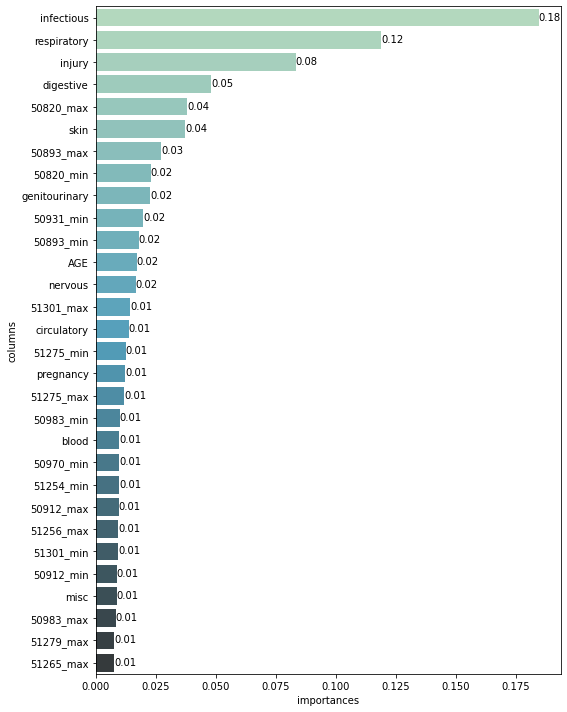

In [ ]:
# 시각화
fig = plt.figure(figsize=(8,10))
ax = sns.barplot(df_feat_imp_30['importances'],df_feat_imp_30['columns'], palette='GnBu_d')
ax.set_yticklabels(df_feat_imp_30['columns'], fontsize=10)

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()))
  initialx+=1

plt.tight_layout()
plt.show()